In [18]:
# ===============================
# STEP 1: Data Collection via API
# ===============================

import requests
import pandas as pd

def get_weather(city_lat, city_lon, start_date="2025-09-01", end_date="2025-09-07"):
    """
    Fetch hourly temperature data for a given city.
    """
    url = (
        f"https://api.open-meteo.com/v1/forecast?"
        f"latitude={city_lat}&longitude={city_lon}"
        f"&hourly=temperature_2m&start_date={start_date}&end_date={end_date}"
        f"&timezone=America%2FNew_York"
    )
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame({
        "time": data["hourly"]["time"],
        "temperature": data["hourly"]["temperature_2m"]
    })
    return df


city1 = get_weather(40.7580, 73.9855)
city2 = get_weather(33.7501, 84.3885)

city1["city"] = "New York"
city2["city"] = "Atlanta"

print("City 1 (before sampling):", len(city1))
print("City 2 (before sampling):", len(city2))

city1 = city1.sample(n=100, random_state=42)
city2 = city2.sample(n=100, random_state=42)

print("City 1 (after sampling):", len(city1))
print("City 2 (after sampling):", len(city2))

df_weather = pd.concat([city1, city2])
df_weather["time"] = pd.to_datetime(df_weather["time"])
df_weather.head()


City 1 (before sampling): 168
City 2 (before sampling): 168
City 1 (after sampling): 100
City 2 (after sampling): 100


,time,temperature,city
137,2025-09-06 17:00:00,16.0,New York
30,2025-09-02 06:00:00,22.8,New York
119,2025-09-05 23:00:00,18.4,New York
29,2025-09-02 05:00:00,23.2,New York
142,2025-09-06 22:00:00,16.2,New York


Hypothesis: The average temperature of Downtown, Atlanta is higher than the average temperature of Times Square, New York from 1st September, 2025 to 7th September, 2025.

Optimization Criteria: The data collected is uniformly distributed and highly accurate. (temperature vs time)

Independent Variable: Location of City (New York and Atlanta)

Dependent Variable: Temperature (Degree Celcius)

City 1 Mean Temp (New York): 20.75
City 2 Mean Temp (Atlanta): 23.44

A/B Test Results:
t-statistic: 5.12  | p-value: 0.0
=> Significant difference detected!


<Figure size 800x500 with 0 Axes>

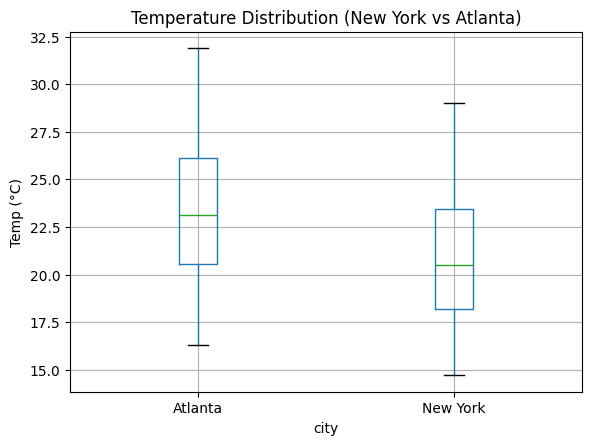

In [13]:
# ===============================
# STEP 2: Mini A/B Test
# ===============================

from scipy import stats
import matplotlib.pyplot as plt

# Split data
city1_temps = df_weather[df_weather["city"]=="New York"]["temperature"]
city2_temps = df_weather[df_weather["city"]=="Atlanta"]["temperature"]

# Compute means
print("City 1 Mean Temp (New York):", round(city1_temps.mean(), 2))
print("City 2 Mean Temp (Atlanta):", round(city2_temps.mean(), 2))

# T-test
t_stat, p_val = stats.ttest_ind(city2_temps, city1_temps, equal_var=False)
print("\nA/B Test Results:")
print("t-statistic:", round(t_stat,3), " | p-value:", round(p_val,5))

if p_val < 0.05:
    print("=> Significant difference detected!")
else:
    print("=> No significant difference detected.")

# Visualization
plt.figure(figsize=(8,5))
df_weather.boxplot(column="temperature", by="city")
plt.title("Temperature Distribution (New York vs Atlanta)")
plt.suptitle("")
plt.ylabel("Temp (°C)")
plt.show()


1. Compare means:
(a) Which city has the higher average temperature?
Answer: Atlanta has a higher average temperature.
(b) Does this support your original hypothesis?
Answer: Yes, this supports my originial hypothesis.

2. Statistical significance:
(a) Look at the p-value. Is the difference statistically significant?
Answer: Yes, the difference is statistically significant. As the p-value (0.0 <0.05)
(b) What does “significant” mean in this context?
Answer: "Significant" in this context tells us about the avg. temperature in both the cities are real and accurately extracted from the dataset. Hence, it is not just any random value or a bluff.

3. Boxplot interpretation:
(a) Which city shows more variability in temperature?
Answer: Atlanta has more variability in temperature because it has more IQR.
(b) Are there any outliers?
Answer: No
(c) How does the boxplot confirm or challenge the t-test results?
Answer: The boxplot confirms the t-test as it shows that Atlanta is above New York, like the median is higher.

In [14]:
# ===============================
# STEP 3: Sampling Bias
# ===============================

# Extract hour from timestamp (allows us to filter the dataset by specific times of day, e.g., only daytime hours, to simulate biased sampling.)
df_weather["hour"] = df_weather["time"].dt.hour

# Example biased sample: daytime only (10am - 4pm)
city1_day = df_weather[(df_weather["city"]=="New York") & (df_weather["hour"].between(10,16))]["temperature"]
city2_day = df_weather[(df_weather["city"]=="Atlanta") & (df_weather["hour"].between(10,16))]["temperature"]

# Compute mean temperature for the full dataset (all hours).
print("FULL SAMPLE MEANS:")
print("New York:", round(city1_temps.mean(),2), "| Atlanta:", round(city2_temps.mean(),2))

# Compute mean temperature for the biased daytime subset.
print("\nDAYTIME SAMPLE MEANS:")
print("New York:", round(city1_day.mean(),2), "| Atlanta:", round(city2_day.mean(),2))

# T-test on biased sample
t_stat, p_val = stats.ttest_ind(city2_day, city1_day, equal_var=False)
print("\nDaytime A/B Test Results:")
print("t-statistic:", round(t_stat,3), " | p-value:", round(p_val,5))


FULL SAMPLE MEANS:
New York: 20.75 | Atlanta: 23.44

DAYTIME SAMPLE MEANS:
New York: 24.21 | Atlanta: 26.48

Daytime A/B Test Results:
t-statistic: 2.835  | p-value: 0.00637


Step 4: Reflection:-

1. Did the A/B test results differ between full and biased samples? Why?
Answer: Yes, the A/B test results differ between full and biased samples. We can see that the mean temperature during daytime is higher than the full sample mean. This affects the p-value and can cause insignifance in the test.

2. How could sampling bias affect real-world conclusions?
Answer: Sampling bias can lead to an inaccurate and ineffective real-world conclusions since they will not evaluate the entire factors and sometimes can work upon the small sample size which does not represent the entire population truely. This can lead to an incorrect decision making.


3. If you were to improve this experiment, what would you do differently?
Answer: To improve this experiment, I would use a uniform sampling for 24hours because this will waive off the bias caused by sampling from only daytime. Hence, a large dataset would help me in getting a non-bas result, which will help in a better policy making.

!!! MINI EXPERIMENT !!!

Step 1: Choose Your API / Dataset

API / Dataset: Open-Meteo API (hourly temperature data)

Two groups/conditions: Mumbai and Tokyo

Control / Treatment assignment: Control- Mumbai and Treatment- Tokyo

In [15]:
# ===============================
# STEP 1: Data Collection via API
# ===============================

import requests
import pandas as pd

def get_weather(city_lat, city_lon, start_date="2025-09-01", end_date="2025-09-07"):
    """
    Fetch hourly temperature data for a given city.
    """
    url = (
        f"https://api.open-meteo.com/v1/forecast?"
        f"latitude={city_lat}&longitude={city_lon}"
        f"&hourly=temperature_2m&start_date={start_date}&end_date={end_date}"
        f"&timezone=America%2FNew_York"
    )
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame({
        "time": data["hourly"]["time"],
        "temperature": data["hourly"]["temperature_2m"]
    })
    return df


city1 = get_weather(19.0728, 72.8826)
city2 = get_weather(35.6895, 139.6917)

city1["city"] = "Mumbai"
city2["city"] = "Tokyo"

print("City 1 (before sampling):", len(city1))
print("City 2 (before sampling):", len(city2))

city1 = city1.sample(n=100, random_state=42)
city2 = city2.sample(n=100, random_state=42)

print("City 1 (after sampling):", len(city1))
print("City 2 (after sampling):", len(city2))

df_weather = pd.concat([city1, city2])
df_weather["time"] = pd.to_datetime(df_weather["time"])
df_weather.head()


City 1 (before sampling): 168
City 2 (before sampling): 168
City 1 (after sampling): 100
City 2 (after sampling): 100


,time,temperature,city
137,2025-09-06 17:00:00,26.6,Mumbai
30,2025-09-02 06:00:00,27.0,Mumbai
119,2025-09-05 23:00:00,26.9,Mumbai
29,2025-09-02 05:00:00,27.0,Mumbai
142,2025-09-06 22:00:00,26.8,Mumbai


Step 2: Write Your Hypothesis

Hypothesis: Mumbai will have a higher mean temperature than Tokyo from 1st September,2025 to 7th September, 2025.

IV: City Location (Mumbai and Tokyo).

DV: Temperature (in Degree Celcius).

Optimization criteria (what you want to maximize/minimize): Highly accuarte data which is equally distributed throughout.


City 1 Mean Temp (Mumbai): 26.94
City 2 Mean Temp (Tokyo): 26.9

A/B Test Results:
t-statistic: -0.107  | p-value: 0.91491
=> No significant difference detected.


<Figure size 800x500 with 0 Axes>

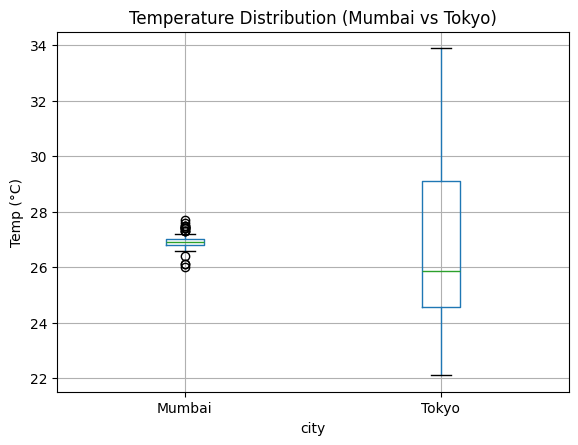

In [16]:
# ===============================
# STEP 3: Mini A/B Test
# ===============================

from scipy import stats
import matplotlib.pyplot as plt

# Split data
city1_temps = df_weather[df_weather["city"]=="Mumbai"]["temperature"]
city2_temps = df_weather[df_weather["city"]=="Tokyo"]["temperature"]

# Compute means
print("City 1 Mean Temp (Mumbai):", round(city1_temps.mean(), 2))
print("City 2 Mean Temp (Tokyo):", round(city2_temps.mean(), 2))

# T-test
t_stat, p_val = stats.ttest_ind(city2_temps, city1_temps, equal_var=False)
print("\nA/B Test Results:")
print("t-statistic:", round(t_stat,3), " | p-value:", round(p_val,5))

if p_val < 0.05:
    print("=> Significant difference detected!")
else:
    print("=> No significant difference detected.")

# Visualization
plt.figure(figsize=(8,5))
df_weather.boxplot(column="temperature", by="city")
plt.title("Temperature Distribution (Mumbai vs Tokyo)")
plt.suptitle("")
plt.ylabel("Temp (°C)")
plt.show()


In [17]:
# ===============================
# STEP 4: Sampling Bias
# ===============================

# Extract hour from timestamp (allows us to filter the dataset by specific times of day, e.g., only daytime hours, to simulate biased sampling.)
df_weather["hour"] = df_weather["time"].dt.hour

# Example biased sample: daytime only (10am - 4pm)
city1_day = df_weather[(df_weather["city"]=="Mumbai") & (df_weather["hour"].between(10,16))]["temperature"]
city2_day = df_weather[(df_weather["city"]=="Tokyo") & (df_weather["hour"].between(10,16))]["temperature"]

# Compute mean temperature for the full dataset (all hours).
print("FULL SAMPLE MEANS:")
print("Mumbai:", round(city1_temps.mean(),2), "| Tokyo:", round(city2_temps.mean(),2))

# Compute mean temperature for the biased daytime subset.
print("\nDAYTIME SAMPLE MEANS:")
print("Mumbai:", round(city1_day.mean(),2), "| Tokyo:", round(city2_day.mean(),2))

# T-test on biased sample
t_stat, p_val = stats.ttest_ind(city2_day, city1_day, equal_var=False)
print("\nDaytime A/B Test Results:")
print("t-statistic:", round(t_stat,3), " | p-value:", round(p_val,5))


FULL SAMPLE MEANS:
Mumbai: 26.94 | Tokyo: 26.9

DAYTIME SAMPLE MEANS:
Mumbai: 27.07 | Tokyo: 24.62

Daytime A/B Test Results:
t-statistic: -9.672  | p-value: 0.0


1. Does your analysis support your hypothesis? 
Answer: Yes, my hypothesis regarding mumbai having a higher mean temperature than Tokyo is correct as the median in the box-plot confirms it.

2. Reflect on limitations, potential bias, and what you learned.
Answer:

Limits: The data range is quite less, 7 days is not enough to make the conclusions. There also can be other factors like seasonal changes and all which will also alter the result.

Potential Bias: Sampling the data for only a specific hours can lead to bias because they may be deceptive. Also, there can be weather factors (external), which will also affect the decision's result.

Learning: From this in-class activity, I have learnt how to collect data from different sources like API's, to perform hypothesis and analyze the independent and dependent variables, to perform A/B testing, check for sampling bias, learn about the role of t-test and p-test, and also make conclusions about the result.